[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkComplexity2/blob/master/examples/fof_student.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Make the figures smaller to save some screen real estate.
# The figures generated for the book have DPI 400, so scaling
# them by a factor of 4 restores them to the size in the notebooks.
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]

In [3]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [4]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [5]:
from utils import decorate

The following are functions from *Probably Overthinking It*, the book, that I used in the chapter on long tailed distributions.

In [6]:
from empiricaldist import Pmf, Surv

def make_surv(seq):
    """Make a non-standard survival function, P(X>=x)"""
    pmf = Pmf.from_seq(seq)
    surv = pmf.make_surv() + pmf

    # correct for numerical error
    surv.iloc[0] = 1
    return Surv(surv)


In [7]:
from scipy.optimize import minimize


def minimize_df(df0, surv, bounds=[(1, 1e6)], ps=None):
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high * 1.2, 2000)

    if ps is None:
        t = surv.ps[0], surv.ps[-2]
        low, high = np.log10(t)
        ps = np.logspace(low, high, 30, endpoint=False)

    qs = surv.inverse(ps)

    def error_func_tail(params):
        (df,) = params
        # print(df)
        mu, sigma = fit_truncated_t(df, surv)
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        errors = np.log10(surv(qs)) - np.log10(surv_model(qs))
        return np.sum(errors**2)

    params = (df0,)
    res = minimize(error_func_tail, x0=params, bounds=bounds, tol=1e-3, method="Powell")
    assert res.success
    return res.x

In [8]:
def truncated_t_sf(qs, df, mu, sigma):
    ps = t_dist.sf(qs, df, mu, sigma)
    surv_model = Surv(ps / ps[0], qs)
    return surv_model

In [9]:
from scipy.optimize import least_squares


def fit_truncated_t(df, surv):
    """Given df, find the best values of mu and sigma."""
    low, high = surv.qs.min(), surv.qs.max()
    qs_model = np.linspace(low, high, 1000)
    ps = np.linspace(0.01, 0.9, 20)
    qs = surv.inverse(ps)

    def error_func_t(params, df, surv):
        # print(params)
        mu, sigma = params
        surv_model = truncated_t_sf(qs_model, df, mu, sigma)

        error = surv(qs) - surv_model(qs)
        return error

    pmf = surv.make_pmf()
    pmf.normalize()
    params = pmf.mean(), pmf.std()
    res = least_squares(error_func_t, x0=params, args=(df, surv), xtol=1e-3)
    assert res.success
    return res.x


In [10]:
from scipy.stats import binom


def empirical_error_bounds(surv, n, qs, con_level=0.95):
    """Find the bounds on a CDF analytically."""
    # find the correct probabilities
    ps = surv.make_cdf()(qs)

    # find the upper and lower percentiles of
    # a binomial distribution
    p_low = (1 - con_level) / 2
    p_high = 1 - p_low

    low = binom.ppf(p_low, n, ps) / n
    low[ps == 1] = 1
    high = binom.ppf(p_high, n, ps) / n
    return 1 - low, 1 - high

In [11]:
from utils import underride


def plot_error_bounds(surv, n, **options):
    underride(options, linewidth=0, alpha=0.1, capstyle="round")
    qs = np.linspace(surv.qs.min(), surv.qs.max(), 100)
    low, high = empirical_error_bounds(surv, n, qs)

    # plt.plot(xs, med, alpha=0.5, label=label, **options)
    plt.fill_between(qs, low, high, **options)

## Student-t Distribution

The following section develops and tests the function I use to estimate the parameters of a Student-t distribution.

In [12]:
from scipy.stats import t as t_dist

mu = 0
sigma = 1
df = 15

rvs = t_dist(df, mu, sigma).rvs(size=1000000)

In [13]:
mags = pd.Series(rvs)

In [14]:
surv = make_surv(mags)
surv.ps[0] == 1

True

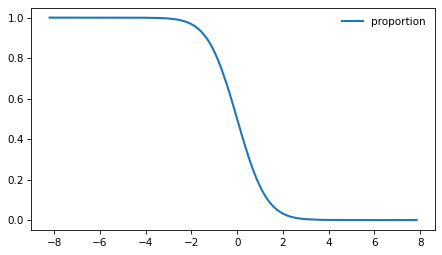

In [15]:
surv.plot()
decorate()

## Fit a t distribution

In [16]:
def make_model(surv, start=5, bounds=(1, 100)):
    df = minimize_df(start, surv, [bounds])
    print(df)

    mu, sigma = fit_truncated_t(df, surv)
    print(mu, sigma)

    low, high = surv.qs.min(), surv.qs.max()
    qs = np.linspace(low, 1.1 * high, 1000)
    surv_model = truncated_t_sf(qs, df, mu, sigma)

    return surv_model

In [17]:
def plot_two(surv, surv_model, n, hatch=None, title=""):
    """Plots tail distributions on linear-y and log-y scales

    surv: Surv
    surv_model: Surv
    n: sample size passed to plot_error_bounds
    hatch: string passed to fill_between
    title: string title

    Uses global variables model_label, ylabel, xlabel, xticks, yticks, xlabels, ylabels
    """
    fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

    plt.sca(axs[0])
    surv_model.plot(color="gray", alpha=0.4, label=model_label)
    if n < 1000:
        plot_error_bounds(Surv(surv_model), n, color="gray")
    surv.plot(color="C1", ls="--", label="Data")
    decorate(ylabel=ylabel, title=title)

    plt.sca(axs[1])
    surv_model.plot(color="gray", alpha=0.4, label=model_label)
    plot_error_bounds(Surv(surv_model), n, color="gray", hatch=hatch)
    surv.plot(color="C2", ls="--", label="Data")
    decorate(xlabel=xlabel, ylabel=ylabel, yscale="log")
    # plt.xticks(xticks, xlabels)
    # plt.yticks(yticks, ylabels)

    plt.tight_layout()
    return axs

In [18]:
surv_model = make_model(surv)

[14.75316951]
-0.010864181554081219 1.0020101302261297


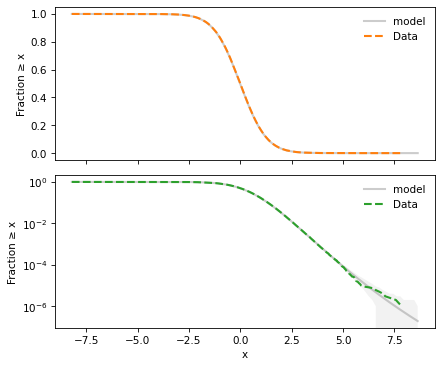

In [19]:
model_label = "model"
xlabel = "x"
ylabel = "Fraction ≥ x"
axs = plot_two(surv, surv_model, len(mags))

The student t model is useful for exploring debates about whether a distribution is more like lognormal or more like Pareto.

As `df` approaches 100, the t distribution approaches Gaussian, and the tail has negative curvature throughout.
When `df` is near 15, it has a straight line tail.
With smaller values of `df`, the tail has positive curvature.

## Real data

In [20]:
DATA_PATH = "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/"
filename = "quake.csv"
download(DATA_PATH + filename)

In [21]:
quake_df = pd.read_csv(filename, low_memory=False)
quake_df.shape

(803451, 4)

In [22]:
mags = quake_df["MAG"]
mags.describe()

count    803451.000000
mean          1.388616
std           0.658252
min           0.000000
25%           0.900000
50%           1.300000
75%           1.800000
max           7.300000
Name: MAG, dtype: float64

In [23]:
n = mags.count()
surv = make_surv(mags)

In [24]:
df = minimize_df(10, surv, [(0, 20)])
mu, sigma = fit_truncated_t(df, surv)
df, mu, sigma

(array([9.076386]), 1.363455560430928, 0.6375531964743555)

In [25]:
low, high = surv.qs.min(), surv.qs.max()
qs = np.linspace(low, 1.1 * high, 2000)
surv_model2 = truncated_t_sf(qs, df, mu, sigma)

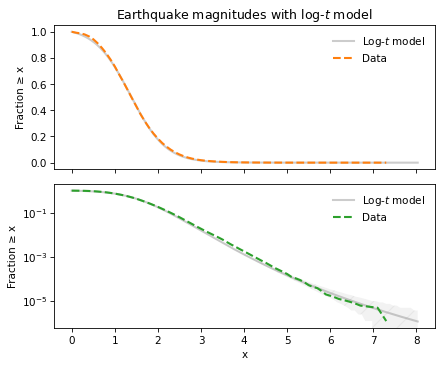

In [26]:
model_label = "Log-$t$ model"
xticks = np.arange(9)
xlabels = xticks
axs = plot_two(
    surv,
    surv_model2,
    n,
    hatch="/",
    title="Earthquake magnitudes with log-$t$ model",
)
plt.tight_layout()

## Facebook data

The following function reads a file with one edge per line, specified by two integer node IDs.

In [27]:
import networkx as nx


def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

We'll read the Facecook data downloaded from [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html)

In [28]:
download("https://snap.stanford.edu/data/facebook_combined.txt.gz")

In [29]:
fb = read_graph("facebook_combined.txt.gz")
n = len(fb)
m = len(fb.edges())
n, m

(4039, 88234)

The average clustering coefficient is about 0.6

In [30]:
from networkx.algorithms.approximation import average_clustering

In [31]:
C = average_clustering(fb)
C

0.634

The average path length is short.

In [32]:
def random_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = G.nodes()
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair) for pair in pairs]
    return lengths


def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(random_path_lengths(G, nodes, trials))

In [33]:
L = estimate_path_length(fb)
L

3.68

## BA model

Here's a simplified version of the NetworkX function that generates BA graphs.

In [34]:
import random

# modified version of the NetworkX implementation from
# https://github.com/networkx/networkx/blob/master/networkx/generators/random_graphs.py


def barabasi_albert_graph(n, m, seed=None):
    """Returns a random graph according to the Barabási–Albert preferential
    attachment model.
    A graph of `n` nodes is grown by attaching new nodes each with `m`
    edges that are preferentially attached to existing nodes with high degree.
    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : int, optional
        Seed for random number generator (default=None).
    Returns
    -------
    G : Graph
    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``.
    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            "Barabási–Albert network must have m >= 1"
            " and m < n, m = %d, n = %d" % (m, n)
        )

    if seed is not None:
        random.seed(seed)

    G = nx.empty_graph(m)
    targets = list(range(m))
    repeated_nodes = []

    for source in range(m, n):

        G.add_edges_from(zip([source] * m, targets))

        repeated_nodes.extend(targets)
        repeated_nodes.extend([source] * m)

        targets = _random_subset(repeated_nodes, m)

    return G


def _random_subset(repeated_nodes, m):
    """Generates a random subset without repetition.

    repeated_nodes: sequence of nodes
    m: number of nodes to sample

    returns: set of nodes
    """
    targets = set()
    while len(targets) < m:
        x = random.choice(repeated_nodes)
        targets.add(x)
    return targets

I'll generate a BA graph with the same number of nodes and edges as the Facebook data:

In [35]:
n = len(fb)
m = len(fb.edges())
k = int(round(m / n))
n, m, k

(4039, 88234, 22)

Providing a random seed means we'll get the same graph every time.

In [36]:
ba = barabasi_albert_graph(n, k, seed=15)

The number of edges is pretty close to what we asked for.

In [37]:
len(ba), len(ba.edges()), len(ba.edges()) / len(ba)

(4039, 88374, 21.88016835850458)

So the mean degree is about right.

In [38]:
def degrees(G):
    """List of degrees for nodes in `G`.

    G: Graph object

    returns: list of int
    """
    return [G.degree(u) for u in G]

In [39]:
np.mean(degrees(fb)), np.mean(degrees(ba))

(43.69101262688784, 43.76033671700916)

The standard deviation of degree is a bit lower than it should be (but much better than the WS model).

In [40]:
np.std(degrees(fb)), np.std(degrees(ba))

(52.41411556737521, 41.03760075705614)

The characteristic path length is even smaller in the model than in the data.

In [41]:
L, estimate_path_length(ba)

(3.68, 2.534)

But the clustering coefficient isn't even close.

In [42]:
C, average_clustering(ba)

(0.634, 0.048)

In the BA model, the degree distribution is better than in the WS model, but the clustering coefficient is too low.

## Cumulative distributions

In [43]:
from empiricaldist import Cdf

cdf_fb = Cdf.from_seq(degrees(fb), name="Facebook")
cdf_ba = Cdf.from_seq(degrees(ba), name="BA model")

If we plot them on a log-x scale, we get a sense of how well the models fit the central part of the distribution.

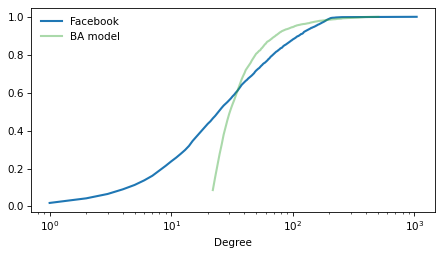

In [44]:
cdf_fb.plot(color="C0", label="Facebook")
cdf_ba.plot(color="C2", alpha=0.4)
decorate(xlabel="Degree", xscale="log")

The BA model is ok for values above the median, but not very good for smaller values.

On a log-log scale, we see that the BA model fits the tail of the distribution reasonably well.

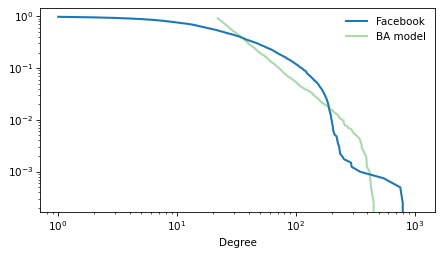

In [45]:
(1 - cdf_fb).plot(color="C0", label="Facebook")
(1 - cdf_ba).plot(color="C2", alpha=0.4)
decorate(xlabel="Degree", xscale="log", yscale="log")

## FOF model

The generative model I propose is called FOF for "friends of friends".  It is similar to both BA and HK, but it yields a degree distribution that matches observed data better.

It starts with a complete graph with `m` nodes, so initially all nodes have degree `m`.  Each time we generate a node we:

1.  Select a random target uniformly from existing nodes.
2.  Iterate through the friends of the target.  For each one, with probability `p`, we form a triangle that includes the source, friend, and a random friend of friend.
3.  Finally, we connect the source and target.

Because we choose friends of the target, this process has preferential attachment, but it does not yield a power law tail.  Rather, the degree distribution is approximately lognormal with median degree `m`.

Because this process forms triangles, it tends to yield a moderately high clustering coefficient.

Here's what my implementation looks like:

In [46]:
def fof_graph(n, m, p=0.25, seed=None):
    """Makes a small world graph with a lognormal degree distribution."""
    if m < 1 or m + 1 >= n:
        raise nx.NetworkXError(
            "FOF network must have m>=1 and m+1<n, m=%d,n=%d" % (m, n)
        )
    if seed is not None:
        random.seed(seed)

    # start with a completely connected core
    G = nx.complete_graph(m + 1)
    G.name = "fof_graph(%s,%s)" % (n, m)

    for source in range(len(G), n):
        # choose a random node
        target = random.choice(list(G.nodes))

        # enumerate neighbors of target and add triangles
        friends = list(G.neighbors(target))
        for friend in friends:
            if flip(p):
                triangle(G, source, friend)

        # connect source and target
        G.add_edge(source, target)

    return G


def flip(p):
    return random.random() < p


def triangle(G, source, friend):
    """Chooses a random neighbor of `friend` and makes a triangle.

    Triangle connects `source`, `friend`, and a random neighbor of `friend`.
    """
    fof = set(G[friend])
    if source in G:
        fof -= set(G[source])
    if fof:
        w = random.choice(list(fof))
        G.add_edge(source, w)
    G.add_edge(source, friend)

The parameter `m` is the average degree.

In [47]:
n = len(fb)
m = int(round(np.mean(degrees(fb))))
n, m

(4039, 44)

The parameter `p` is the probability of adding a triangle.  Since each triangle increases the total degree by 4, keeping `p` near `1/4` tends to keep `m` constant.

In [48]:
fof = fof_graph(n, m, p=0.24, seed=21)
len(fof), len(fof.edges())

(4039, 83137)

The clustering coefficient is similar to what we get from the HK model.

In [49]:
C, average_clustering(fof)

(0.634, 0.257)

The average path length is low.

In [50]:
L, estimate_path_length(fof)

(3.68, 3.185)

The degree distribution fits the observed data well

In [51]:
cdf_fof = Cdf.from_seq(degrees(fof), name="FOF")

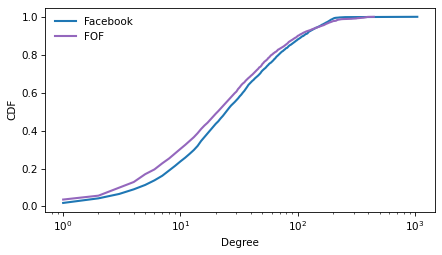

In [52]:
cdf_fb.plot(color="C0")
cdf_fof.plot(color="C4")

decorate(xlabel="Degree", ylabel="CDF", xscale="log")

On a log-log scale, the model fits the data well except in the extreme tail.

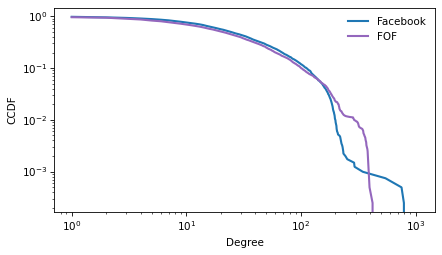

In [53]:
(1 - cdf_fb).plot(color="C0")
(1 - cdf_fof).plot(color="C4")

decorate(xlabel="Degree", ylabel="CCDF", xscale="log", yscale="log")

## Degree distributions

Is the t distribution a good model for the degree distribution

* observed on Facebook
* generated by the FOF model

In [54]:
mags = np.log10(degrees(fb))

In [55]:
surv = make_surv(mags)

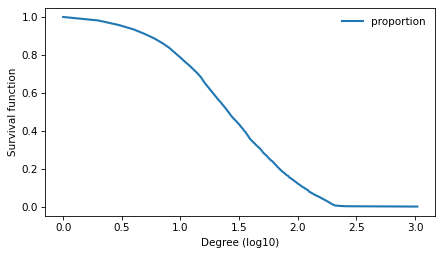

In [56]:
surv.plot()
decorate(xlabel="Degree (log10)", ylabel="Survival function")

In [57]:
stop

NameError: name 'stop' is not defined

In [ ]:
surv_model = make_model(surv)

In [ ]:
model_label = "model"
xlabel = "x"
ylabel = "Fraction ≥ x"
axs = plot_two(surv, surv_model, len(mags))

## Bigger dataset

https://snap.stanford.edu/data/soc-LiveJournal1.html

In [ ]:
download(
    "https://github.com/AllenDowney/ThinkComplexity2/raw/master/examples/soc_livejournal_degree.hdf"
)

In [ ]:
node_series = pd.read_hdf("soc_livejournal_degree.hdf", key="node_series")
mags = np.log10(node_series)
mags.describe()

In [ ]:
Cdf.from_seq(mags).plot()

In [ ]:
stop

In [ ]:
download("https://snap.stanford.edu/data/soc-LiveJournal1.txt.gz")

In [ ]:
import gzip
import io
from collections import Counter

filename = 'soc-LiveJournal1.txt.gz'
nodes = Counter()

# Open the gzipped file in binary mode
with gzip.open(filename, 'rb') as f:
    # Wrap the file object in an io.TextIOWrapper to read it as text
    with io.TextIOWrapper(f, encoding='utf-8') as text_file:
        # Loop through the first 100 lines
        for _ in range(4):
            line = text_file.readline()
            
        for _ in range(100000000):
            line = text_file.readline()
            if line:
                source, dest = line.split()
                nodes[source] += 1
                nodes[dest] += 1


In [ ]:
len(nodes)

In [ ]:
mags = np.log10(list(nodes.values()))

In [ ]:
node_series = pd.Series(nodes)

In [ ]:
!rm soc_livejournal_degree.hdf

In [ ]:
node_series.to_hdf("soc_livejournal_degree.hdf", key="node_series", complevel=6)

In [ ]:
!ls -lh soc_livejournal_degree.hdf

In [ ]:
!git add soc_livejournal_degree.hdf
!git commit -m "Adding livejournal degree data"
!git push